In [1]:
import pandas as pd #импортируем библиотеку pandas
import numpy as np #импортируем библиотеку numpy
import statistics
from scipy import stats as st

#последовательно читаем каждую из доступных таблиц
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')

<a id='Знакомство с данными и предобработка'></a>
## 1. Знакомство с данными и предобработка

Перед анализом данных нам необходимо ознакомиться с ними и убедиться, что все значения в таблицах пригодны для дальнейшей обработки и не создадут искажений в цифрах. В рамках проекта мы располагаем 5 разными таблицами, но начнем предобработку с таблицы пользователей.

<a id='Таблица `users`'></a>
### 1.1 Таблица `users`

In [2]:
#ознакомимся с типами данных в столбцах и качеством их заполнения
users.info()
users.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
198,1198,26,NaN,Ярославль,Эдуард,Швецов,2018-08-15,smart
92,1092,73,NaN,Ижевск,Вениамин,Амельченко,2018-06-19,smart
270,1270,18,NaN,Нижневартовск,Мальвина,Вешнякова,2018-07-01,ultra


<span style="text-decoration:underline">Несколько выводов:</span>
1. В столбце `churn_date` всего 38 значений из 500. Этот столбец не обязателен к заполнению => вероятней всего 38 пользователей из нашей выборки прекратили пользоваться тем тарифным планом, который указан в соответствующей строке
2. В столбце `reg_date` используется строковый тип данных, хотя в нем указана дата

<span style="text-decoration:underline">Требуется проделать следующее:</span>
1. Проверить наличие идентичных идентификаторов пользователей в столбце `user_id`, так как описание принципа, по которому значение попадает в этот столбец может подразумевать формирование новой записи в БД для уже существующего пользователя при изменении тарифного плана
2. Преобразовать строковый тип данных столбцов `reg_date` и `churn_date` в дату
3. Проверить корректность использованных значений и, при необходимости, исправить их

In [3]:
#при помощи функции len мы измеряем длину массива (Series), в который отбираем значения столбца user_id
len(users['user_id'].unique())

500

In [4]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
#преобразуем значения столбцов 'reg_date' и 'churn_date' в дату из строки

In [5]:
#взглянем на столбец с возрастом абонентов
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Ничего необычного.

Имеет смысл также убедиться, что в столбцах `city` и `tariff` все значения записаны корректно, так как возможные варианты здесь - категориальные переменные, поэтому различное написание идентичных по смыслу городов или тарифов не допускается, так как может появиться искажение при анализе данных с использованием этих ключей.

In [6]:
#смотрим распределение наблюдений по столбцу tariff и видим, что уникальных значений используется 
#всего два - это корректно
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [7]:
#так количество возможных значений в столбце city значительно больше различных вариаций тарифных планов,
#мы обратимся в массиву с названиями городов из датафрейма, отсортируем его, сформируем диапазон уникальных значений
#и выведем этот диапазон на экран для визуальной оценки
display(users['city'].sort_values().unique())

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Мы видим, что столбец с наименованиями городов также заполнен корректными значениями.

<a href='#Оглавление'> К оглавлению</a>

<a id='Таблица `calls`'></a>
### 1.2 Таблица `calls`

In [9]:
calls.info()
calls.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
152089,1379_324,2018-09-06,12.76,1379
106484,1274_480,2018-10-12,7.04,1274
37480,1094_100,2018-07-01,4.16,1094


<span style="text-decoration:underline">Несколько выводов:</span>
1. В таблице 4 столбца и все 4 заполнены идентично - по 202607 значений в каждом столбце. Следовательно, пропусков в таблице нет
2. Столбец `call_date` заполнен строковым значением, хотя содержит данные о дате совершения звонка
3. Столбец `duration` заполнен числами с плавающей точкой, что корректно с точки зрения учета, но нам известна особенность биллинга оператора - округление продолжительности разговора в большую сторону до числа кратного 60, то есть до минут. Поэтому данные столбца вполне можно преобразовать в целое число

<span style="text-decoration:underline">Требуется проделать следующее:</span>
1. Преобразовать значения столбца `call_date` в дату
2. Округлить значения столбца `duration` в сторону повышения и преообразовать полученные значения в целые числа

In [10]:
#Методом, аналогичным ранее использованному, мы преобразуем строковое значение в дату
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [11]:
#используем метод ceil библиотеки numpy для округления вверх и сразу же изменяем тип данных в столбце
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
calls.sample(3)

,id,call_date,duration,user_id
163692,1402_515,2018-08-15,7,1402
55143,1139_28,2018-11-15,0,1139
106684,1275_144,2018-11-27,8,1275


In [12]:
#в качестве предосторожности проверим наличием дублирующих строк по идентификатору звонка
len(calls['id'].unique())

202607

In [13]:
#посмотрим на количество записей о звонках с нулевой продолжительностью
print('Количество записей нулевой продолжительностью разговора:', len(calls.loc[calls['duration'] == 0]))
print('Доля записей с нулевой продолжительностью разговора: {0:.1f}%'\
      .format(len(calls.loc[calls['duration'] == 0]) / len(calls) * 100))

Количество записей нулевой продолжительностью разговора: 39613
Доля записей с нулевой продолжительностью разговора: 19.6%


In [14]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


Таблица готова к использованию.

Около 20% всех значений из таблицы - это звонки с нулевой продолжительностью. Вероятно, это пропущенные звонки. Для анализа экономики тарифов нам эта информация вряд ли пригодится. 

В теории, эти данные можно использовать для анализа поведения абонентов. Учитывая логику построения таблицы, мы можем предположить, что каждый пропущенный звонок - это попытка пользователя услуг связи "нашей" компании куда-то дозвониться, но при отсутствии данных (хотя бы косвенных) о причине "недозвона" будет достаточно сложно сделать какой-то осмысленный вывод на базе этих данных (например, корень причины технический или обусловлен поведением получателя звонка). 

<a href='#Оглавление'> К оглавлению</a>

<a id='Таблица `internet`'></a>
### 1.3 Таблица `internet`

In [15]:
internet.info()
internet.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
129360,129360,1431_394,249.83,2018-09-30,1431
61596,61596,1209_118,343.28,2018-06-29,1209
68944,68944,1233_403,0.00,2018-06-17,1233


<span style="text-decoration:underline">Несколько выводов:</span>
1. Все столбцы заполнены данными
2. Ситуация со столбцом `mb_used` аналогична столбцу `duration` в истории звонков - для биллинга используется округление вверх до ближайшего целого числа
3. Дата подключения к интернету также отражена в виде строки вместо даты

<span style="text-decoration:underline">Требуется проделать следующее:</span>
1. Преобразовать тип данных столбца `session_date` из строкового в дату
2. Округлить вверх и привести к целому значения в столбце `mb_used`

In [16]:
#в датасете образовался столбец с дубликатами индексов строк - его мы просто удалим
del internet['Unnamed: 0']

In [17]:
#Преобразуем дату Интернет-сессии из строкового типа данных в дату
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [18]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)
internet.sample(3)

,id,mb_used,session_date,user_id
73249,1247_287,533,2018-11-18,1247
87186,1295_30,0,2018-10-17,1295
80760,1272_152,53,2018-12-19,1272


In [19]:
#оценка сэмпла данных после преобразования показала, что в таблице есть записи с 0 израсходованных МБайт трафика
#в рамках 1 сессии. Посчитаем количество таких строк в датасете:
#посмотрим на количество записей о звонках с нулевой продолжительностью
print('Количество записей с 0 МБайт трафика в рамках 1 сессии:', len(internet.loc[internet['mb_used'] == 0]))
print('Доля записей с 0 МБайт трафика: {0:.1f}%'.format(len(internet.loc[internet['mb_used'] == 0]) / len(internet) * 100))

Количество записей с 0 МБайт трафика в рамках 1 сессии: 19598
Доля записей с 0 МБайт трафика: 13.1%


<span style="text-decoration:underline">По аналогии с продолжительностью телефонных разговоров, мы можем предположить, что:</span>

1. Сессия с 0 МБайт трафика - это попытка выйти в Интернет
2. Попытка неудачная или прерванная, так как не был израсходован ни 1 КБайт трафика
3. Вероятно, пользователи испытывают проблемы с качеством связи
4. У нас нет привязки к конкретному времени попытки выхода в Интернет, либо конкретной локации в рамках населенного пункта, поэтому на основании таких данных мы можем сформулировать гипотезу о зависимости качества покрытия сети и количества неудачных сессий выхода в Интернет
5. Теоретически, такую логику можно распространить и на телефонные звонки, но в их случае больше условностей - телефонный звонок подразумевает двухсторонюю коммуникацию (другими словами, трубку могли просто не взять), а выход в Интернет в этом отношении проще

Вывод: обработка таких значений не расширяет наши возможности по анализу экономики каждого из тарифных планов, но генерирует дополнительный объем работы для проверки предположений, которые не были поставлены на старте. Следовательно, мы можем отказаться от нулевых значений для поиска ответа на задачу и удалить эти записи из датасета. 

In [20]:
#удаляем "нулевые" строки из таблицы звонков
calls.drop(calls.loc[calls['duration'] == 0].index, inplace=True) 
calls = calls.reset_index(drop=True)

#удаляем "нулевые" строки из таблицы выходов в интернет
internet.drop(internet.loc[internet['mb_used'] == 0].index, inplace=True) 
internet = internet.reset_index(drop=True)

<span style="text-decoration:underline">Важное уточнение:</span>
Пункт 2 из из ранее выдвинутого предположения стоило бы уточнить у инженеров, ответственных за выгрузку данных из учетной системы оператора: 

1. Записи столбца `mb_used` в исходном датасете детализированы до двух знаков после точки
2. 1 МБайт состоит из 1024 КБайт => 1/100 мегабайта == 10.24 КБайт

Из этого вопросы: 

1. Если в процессе выгрузки сессии с объемом трафика <= 10 КБайт (то есть, 0.009 МБайт и менее) приобрели вид '0.00', то израсходованный трафик не может быть учтен при расчете экономики
2. Если значения были округлены, то по какому методу: округление вверх до 1/100 мегабайта, либо по правилам математического округления (то есть, значения 0.0049 МБайт превратились в 0.00 МБайт) - во втором случае неучтенных сессий будет меньше, чем по сценарию из п. 1, но они будут

Таблица готова к использованию.

<a href='#Оглавление'> К оглавлению</a>

<a id='Таблица `messages`'></a>
### 1.4 Таблица `messages`

In [21]:
messages.info()
messages.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
61508,1271_93,2018-08-24,1271
89665,1374_113,2018-07-23,1374
119908,1484_429,2018-08-07,1484


В данной таблице имеет смысл только преобразовать дату из строкового формата в формат даты.

In [22]:
#Преобразуем дату Интернет-сессии из строкового типа данных в дату
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [23]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Таблица готова к использованию.

<a href='#Оглавление'> К оглавлению</a>

<a id='Таблица `tariffs`'></a>
### 1.5 Таблица `tariffs`

In [24]:
tariffs.info()
display(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица тарифов включает всего две записи по количеству тарифов. Типы данных во всех ячейках выбраны корректно. Данные о количестве доступных минут/мегабайт/сообщений также указаны корректно.

<a href='#Оглавление'> К оглавлению</a>

<a id='Описание поведения пользователей'></a>
## 2. Описание поведения пользователей

<a id='Минуты звонков, мегабайты и сообщения по месяцам'></a>
### 2.1 Минуты звонков, мегабайты и сообщения по месяцам

Для подсчета количество израсходованных минут, мегабайт или сообщений для каждого пользователя нам не требуется персонификация каждого - достаточно сгруппировать данные по идентификаторам. 

In [25]:
calls.sample(5)

,id,call_date,duration,user_id
63481,1196_1156,2018-12-18,1,1196
44623,1142_190,2018-10-02,12,1142
135104,1414_118,2018-11-10,3,1414
3479,1011_440,2018-05-04,3,1011
76109,1240_191,2018-03-28,7,1240


In [26]:
#дополняем таблицу звонков отдельным столбцом с номером месяца
calls['call_month'] = calls['call_date'].dt.month

#для комфорта восприятия формируем два датафрейма с группировкой количества звонков и их общей продолжительности
#по месяцам для каждого пользователя
calls_statistics_duration = calls.pivot_table(index='user_id', columns='call_month', values='duration', aggfunc=['sum']).fillna(0).astype(int)
calls_statistics_qty = calls.pivot_table(index='user_id', columns='call_month', values='duration', aggfunc=['count']).fillna(0).astype(int)
calls_statistics_duration.columns=['01_January', '02_February', '03_March', '04_April', '05_May', '06_June', '07_July', '08_August', '09_September', '10_October', '11_November', '12_December']
calls_statistics_duration.sample(3)

,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
user_id,,,,,,,,,,,,
1364,0,0,0,0,0,0,0,87,1040,925,1010,1028
1014,0,0,0,0,102,180,300,241,250,332,237,175
1308,250,261,144,204,213,159,175,337,225,243,197,207


In [27]:
#таблица количества совершенных звонков по месяцам для каждого пользователя
calls_statistics_qty.columns=['01_January', '02_February', '03_March', '04_April', '05_May', '06_June', '07_July', '08_August', '09_September', '10_October', '11_November', '12_December']
calls_statistics_qty.sample(3)

,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
user_id,,,,,,,,,,,,
1256,0,0,0,0,0,0,0,0,7,74,47,73
1259,0,0,0,0,0,0,0,0,0,0,55,88
1342,0,0,0,0,0,0,0,0,0,19,39,72


<span style="text-decoration:underline">Для подсчета выручки нам необходимо:</span>

1. Знать тариф которым пользуется каждый из пользователей => необходимо из таблицы 'users' получить наименования тарифов 
2. Знать детали тарифа => получить из таблицы 'tariffs' цифры количества включенных минут разговора и стоимость каждой дополнительной минуты

In [28]:
#формируем отдельный датасет на базе таблицы пользователей с идентификатором пользователя и тарифом
#далее мы преобразуем столбец user_id в столбец индексов для удобного использования 
user_tafiff = users[['user_id', 'tariff']]
#user_tafiff.set_index('user_id', inplace=True)
user_tafiff.sample(5)

,user_id,tariff
404,1404,smart
154,1154,smart
60,1060,ultra
296,1296,smart
388,1388,smart


In [29]:
#переназначаем индексы в таблицы тарифов для соединения таблиц
tariffs.set_index('tariff_name', inplace=True)

In [30]:
#формируем отдельный датафрейм путем склеивания user_tafiff с ключевыми параметрами для вычисления выручки
#за телефонные звонки
calls_earnings = user_tafiff.join(tariffs, on='tariff')[['user_id', 'tariff', 'minutes_included', 'rub_per_minute']]
calls_earnings = calls_earnings.join(calls_statistics_duration, on='user_id')
calls_earnings.head(10)

,user_id,tariff,minutes_included,rub_per_minute,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
0,1000,ultra,3000,1,0.0,0.0,0.0,0.0,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1,1001,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,430.0,414.0
2,1002,smart,500,3,0.0,0.0,0.0,0.0,0.0,117.0,214.0,289.0,206.0,212.0,243.0,236.0
3,1003,ultra,3000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380.0,961.0,855.0,824.0,802.0
4,1004,ultra,3000,1,0.0,0.0,0.0,0.0,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
5,1005,smart,500,3,95.0,456.0,606.0,712.0,595.0,612.0,569.0,619.0,479.0,723.0,547.0,592.0
6,1006,smart,500,3,0.0,42.0,286.0,356.0,370.0,478.0,316.0,275.0,360.0,267.0,372.0,379.0
7,1007,smart,500,3,0.0,0.0,0.0,198.0,480.0,545.0,577.0,458.0,655.0,465.0,580.0,421.0
8,1008,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,339.0
9,1009,smart,500,3,0.0,0.0,109.0,324.0,170.0,289.0,183.0,249.0,133.0,213.0,290.0,229.0


In [31]:
#пишем функцию для расчета выручки по тарифу за услуги, оказанные свыше заложенных в тариф цифр
#вместо указания именованных индексов ячеек для лимита минут и стоимость минуты используем ссылку на цифровой индекс
#так мы сможем воспользоваться этой же функцией для расчета выручки за использование интернета
def earnings_calculator(row):
    limit = row[2]
    additional_unit_cost = row[3]
    for i in range(4, 16):
        if row[i] <= limit:
            row[i] = 0
        elif row[i] > limit:
            row[i] = (row[i] - limit) * additional_unit_cost
    return row

In [32]:
calls_earnings = calls_earnings.apply(earnings_calculator, axis=1)
calls_earnings.head(10)
#видим, что в таблице стало значительно больше нулей - остались те, кто не укладывается в ограничения тарифа

,user_id,tariff,minutes_included,rub_per_minute,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
0,1000,ultra,3000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003,ultra,3000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004,ultra,3000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1005,smart,500,3,0.0,0.0,318.0,636.0,285.0,336.0,207.0,357.0,0.0,669.0,141.0,276.0
6,1006,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1007,smart,500,3,0.0,0.0,0.0,0.0,0.0,135.0,231.0,0.0,465.0,0.0,240.0,0.0
8,1008,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1009,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
#в таблице со статистикой выхода в Интернет формируем новый столбец с месяцем
internet['session_month'] = internet['session_date'].dt.month

#формируем сводную таблицу с аггрегированными данными по использованному трафику по месяцам для каждого 
#пользователя
internet_statistics_mb = internet.pivot_table(index='user_id', columns='session_month', values='mb_used',\
                                             aggfunc=['sum']).fillna(0).astype(int)
internet_statistics_mb.columns=['01_January', '02_February', '03_March', '04_April', '05_May', '06_June', '07_July', '08_August', '09_September', '10_October', '11_November', '12_December']


internet_earnings = user_tafiff.join(tariffs, on='tariff')[['user_id', 'tariff', 'mb_per_month_included', 'rub_per_gb']]
internet_earnings = internet_earnings.join(internet_statistics_mb, on='user_id')
internet_earnings.head(10)

,user_id,tariff,mb_per_month_included,rub_per_gb,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
0,1000,ultra,30720,150,0.0,0.0,0.0,0.0,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0
1,1001,smart,15360,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18452.0,14053.0
2,1002,smart,15360,200,0.0,0.0,0.0,0.0,0.0,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0
3,1003,ultra,30720,150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8571.0,12479.0,14779.0,11368.0,10132.0
4,1004,ultra,30720,150,0.0,0.0,0.0,0.0,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0
5,1005,smart,15360,200,2730.0,7394.0,11117.0,9365.0,7877.0,9875.0,7703.0,7554.0,7027.0,7809.0,12682.0,8680.0
6,1006,smart,15360,200,0.0,1395.0,17309.0,13954.0,12984.0,12388.0,20000.0,19327.0,15543.0,19722.0,13275.0,18498.0
7,1007,smart,15360,200,0.0,0.0,0.0,8031.0,17708.0,13674.0,15680.0,20723.0,12630.0,14444.0,16390.0,12512.0
8,1008,smart,15360,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13236.0
9,1009,smart,15360,200,0.0,0.0,7359.0,14730.0,13386.0,16084.0,24752.0,23738.0,21954.0,20112.0,16867.0,18642.0


Следует обратить внимание, что в отличие от голосовых вызовов, в данных о стоимости дополнительного трафика есть информация о стоимости 1 ГБайт трафика. Мы можем доработать функцию, которую использовали для расчета выручки сверх тарифа по голосовым вызовам. 

Однако мы предпочтем воспользоваться более простым способом - делением стоимости 1 ГБ на 1024 части (по количеству мегабайт, входящих в 1 ГБайт).

In [34]:
internet_earnings['rub_per_gb'] = internet_earnings['rub_per_gb'] / 1024
internet_earnings.columns=['user_id', 'tariff', 'mb_per_month_included', 'rub_per_mb',\
                            '01_January', '02_February', '03_March', '04_April', '05_May', '06_June', '07_July', '08_August', '09_September', '10_October', '11_November', '12_December']

In [35]:
#применяем нашу функцию и получаем данные о выручке сверх тарифа за интернет
internet_earnings = internet_earnings.apply(earnings_calculator, axis=1)
internet_earnings.head(10)

,user_id,tariff,mb_per_month_included,rub_per_mb,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
0,1000,ultra,30720,0.146484,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1001,smart,15360,0.195312,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,603.906250,0.000000
2,1002,smart,15360,0.195312,0.0,0.0,0.000000,0.0,0.00000,0.00000,437.695312,974.023438,264.062500,0.000000,634.765625,542.382812
3,1003,ultra,30720,0.146484,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1004,ultra,30720,0.146484,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1005,smart,15360,0.195312,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1006,smart,15360,0.195312,0.0,0.0,380.664062,0.0,0.00000,0.00000,906.250000,774.804688,35.742188,851.953125,0.000000,612.890625
7,1007,smart,15360,0.195312,0.0,0.0,0.000000,0.0,458.59375,0.00000,62.500000,1047.460938,0.000000,0.000000,201.171875,0.000000
8,1008,smart,15360,0.195312,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,1009,smart,15360,0.195312,0.0,0.0,0.000000,0.0,0.00000,141.40625,1834.375000,1636.328125,1287.890625,928.125000,294.335938,641.015625


In [36]:
#переходим к текстовым сообщениям и добавляем месяц, в котором было отправлено сообщение
messages['message_month'] = messages['message_date'].dt.month

#собираем таблицу с данными о количестве отправленных сообщений
messages_statistics = messages.pivot_table(index='user_id', columns='message_month', values='id',\
                                          aggfunc=['count']).fillna(0).astype(int)
messages_statistics.columns=['01_January', '02_February', '03_March', '04_April', '05_May', '06_June', '07_July', '08_August', '09_September', '10_October', '11_November', '12_December']

#собираем таблица на которую мы наложим функцию
#следует обратить внимание на NaN у некоторых пользователей - по ним нет статистики отправленных сообщений, 
#поэтому заменяем NaN на нули
messages_earnings = user_tafiff.join(tariffs, on='tariff')[['user_id', 'tariff', 'messages_included', 'rub_per_message']]
messages_earnings = messages_earnings.join(messages_statistics, on='user_id').fillna(0)
messages_earnings.head(10)

,user_id,tariff,messages_included,rub_per_message,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
0,1000,ultra,1000,1,0.0,0.0,0.0,0.0,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1001,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002,smart,50,3,0.0,0.0,0.0,0.0,0.0,4.0,11.0,13.0,4.0,10.0,16.0,12.0
3,1003,ultra,1000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,91.0,83.0,94.0,75.0
4,1004,ultra,1000,1,0.0,0.0,0.0,0.0,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
5,1005,smart,50,3,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
6,1006,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1007,smart,50,3,0.0,0.0,0.0,11.0,39.0,26.0,26.0,27.0,31.0,18.0,21.0,26.0
8,1008,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
9,1009,smart,50,3,0.0,0.0,2.0,14.0,7.0,14.0,14.0,9.0,12.0,15.0,11.0,12.0


<span style="text-decoration:underline">Отсутствие данных по количеству отправленных сообщений может быть следствием двух причин:</span>

1. Некорректная выгрузка данных 
2. Отсутствие спроса на услугу у определенного сегмента пользователей 

Оба причины могут быть гипотезами для более глубокого исследования. Во-втором случае, вероятно, требуется скорректировать маркетинговую стратегию в отношении тарифов с большим количеством включенных текстовых сообщений - есть вероятность, что это уже не является конкурентным преимуществом. 

In [37]:
#в 3 раз используем написанную ранее функцию
messages_earnings = messages_earnings.apply(earnings_calculator, axis=1)
messages_earnings.head(10)

,user_id,tariff,messages_included,rub_per_message,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
0,1000,ultra,1000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003,ultra,1000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004,ultra,1000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1005,smart,50,3,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0
6,1006,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1007,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1008,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
9,1009,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь нам доступны таблицы с количеством израсходованных минут, мегабайт и сообщений для каждого абонента.

Также по каждому виду услуг мы посчитали помесячный доход оператора, если он превышал сумму ежемесячной абонентской платы.

<a href='#Оглавление'> К оглавлению</a>

<a id='Доход от каждого абонента по месяцам'></a>
### 2.2 Доход от каждого абонента по месяцам

In [38]:
#складываем полученные датафреймы по всем источникам прибыли
overall_earnings = calls_earnings.set_index('user_id').add(internet_earnings.set_index('user_id'), fill_value=0)
overall_earnings = overall_earnings.add(messages_earnings.set_index('user_id'), fill_value=0)
overall_earnings = overall_earnings.sort_index(axis=0)

#убираем из датафрейма ненужные столбцы, округляем в сторону повышения до рубля и преобразуем в целые числа
overall_earnings = overall_earnings[['01_January', '02_February', '03_March', '04_April', '05_May', '06_June',\
'07_July', '08_August', '09_September', '10_October', '11_November', '12_December']].apply(np.ceil).astype(int)

#del overall_earnings['mb_per_month_included']
overall_earnings.head(10)


,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
user_id,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,0
1001,0,0,0,0,0,0,0,0,0,0,604,0
1002,0,0,0,0,0,0,438,975,265,0,635,543
1003,0,0,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,0,0
1005,0,0,336,636,285,336,225,399,6,669,144,288
1006,0,0,381,0,0,0,907,775,36,852,0,613
1007,0,0,0,0,459,135,294,1048,465,0,442,0
1008,0,0,0,0,0,0,0,0,0,0,0,18


Мы получили датафрейм, где каждому идентификатору пользователя соответствует сумма дохода, полученная от него за использование дополнительных услуг, не включенных в тариф. 

Теперь нам необходимо добавить к этой сумме ежемесячную абонентскую плату за тариф. 

Так как мы удалили дополнительные столбцы нам необходимо: 

1. Добавить в полученную таблицу столбец с тарифным планом, которым пользуется абонент
2. Так как абонент мог начать пользоваться услугами нашей компании не с начала года, необходимо учесть этот факт при заполнении суммы дохода от абонентской платы
3. Также необходимо учесть тех людей, которые прекратили пользоваться услугами оператора в течение 2018 года

Всеми необходимыми датами мы располагаем в исходных датасетах. Кромет того:

1. У нас отсутствует информация о способе внесения абонентской платы: если она списывается равными долями в течение равных периодов, то в месяц присоединения абонента, либо в месяц его отключения сумма дохода за счет абонентской платы будет ниже
2. Если списание абонентской платы производится единоразово по факту истечения некоего фиксированного временного отрезка, то для некоторых абонентов списание будет производиться со смещением (иногда значительным) от начала месяца

В рамках поставленной задачи мы сделаем допущение, что это нюансы не имеют принципиального значения. 

In [39]:
#дополняем датасет с базой пользователей дополнительными столбцами для проверки в функции учета абонентской платы
users['reg_year'] = users['reg_date'].dt.year
users['reg_month'] = users['reg_date'].dt.month
users['churn_month'] = users['churn_date'].dt.month.fillna(0).astype(int) #укажем 0, если абонент все еще пользуется
#связбю оператора, которого мы анализируем

#проверяем, все ли абоненты зарегистрировались в 2018 году 
users.pivot_table(index='reg_year', values='user_id', aggfunc=['count'])

#шаг1 - формируем таблицу с доходами на базе базы пользователей и полученного датафрейма с доходами
#так мы получаем всю необходимую информацию в рамках 1 таблицы
overall_earnings = users.join(overall_earnings, on='user_id')
overall_earnings = overall_earnings[['user_id', 'reg_date', 'tariff', 'reg_year', 'reg_month', 'churn_month', \
'01_January', '02_February', '03_March', '04_April', '05_May', '06_June', '07_July', '08_August', '09_September',\
'10_October', '11_November', '12_December']]

In [40]:
#шаг2 - создаем функцию для обработки датасета и дополнения его информация о доходе за счет абонентской платы

def tariff_fee_add(row):
    start_index = row['reg_month'] + 5 #стартовый иднекс для цикла, которым в строке мы заполняем значения
    if row['churn_month'] > 0: #если месяц прекращения использования услуг отличен от нуля, то
        end_index = row['churn_month'] + 6 #к нему мы прибавляем смещение и получаем конечный индекс 
    else: #иначе в качестве конечного индекса мы используем длину строки, с которой работаем
        end_index = len(row) 
    if row['tariff'] == 'smart': #на базе значения в ячейке с тарифом, мы определяем значение локальной переменной
        tariff_fee = 500         #tafiff_fee
    else:
        tariff_fee = 3000
    for i in range(start_index, end_index): #далее для каждого значения в диапазоне ячеек строки мы плюсуем аб.плату
        row[i] = row[i] + tariff_fee
    return row

In [41]:
overall_earnings = overall_earnings.apply(tariff_fee_add, axis=1)
overall_earnings.head(10)

,user_id,reg_date,tariff,reg_year,reg_month,churn_month,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
0,1000,2018-05-25,ultra,2018,5,0,0,0,0,0,3000,3000,3000,3000,3000,3000,3000,3000
1,1001,2018-11-01,smart,2018,11,0,0,0,0,0,0,0,0,0,0,0,1104,500
2,1002,2018-06-17,smart,2018,6,0,0,0,0,0,0,500,938,1475,765,500,1135,1043
3,1003,2018-08-17,ultra,2018,8,0,0,0,0,0,0,0,0,3000,3000,3000,3000,3000
4,1004,2018-05-14,ultra,2018,5,0,0,0,0,0,3000,3000,3000,3000,3000,3000,3000,3000
5,1005,2018-01-25,smart,2018,1,0,500,500,836,1136,785,836,725,899,506,1169,644,788
6,1006,2018-02-26,smart,2018,2,0,0,500,881,500,500,500,1407,1275,536,1352,500,1113
7,1007,2018-04-19,smart,2018,4,0,0,0,0,500,959,635,794,1548,965,500,942,500
8,1008,2018-12-19,smart,2018,12,0,0,0,0,0,0,0,0,0,0,0,0,518
9,1009,2018-03-22,smart,2018,3,0,0,0,500,500,500,642,2335,2137,1788,1429,795,1142


<a href='#Оглавление'> К оглавлению</a>

Мы получили таблицу с общим уровнем дохода от каждого абонента с учетом абонентской платы и стоимости услуг, израсходованных свыше включенного в тарифный план объема. 

<a id='Поведение абонентов'></a>
### 2.3 Поведение абонентов

Нам необходимо вычислить среднее количество израсходованных каждым абонентом минут, а также дисперсию и стандартное отклонение. Однако для разных абонентов период использования услуг связи будет разным в силу отличных дат подключения к оператору и, возможно, отключения. 

Если мы учтем нулевые значения, то сильно сместим центральную тенденцию влево, поэтому необходима функция, которая учтет разные периоды. 

При подготовке функции мы будем исходить из предположения о том, что для расчета параметров используются только значения больше нуля.

In [42]:
def statistics_calculator(row):
    base = [] #формируем пустой список, который мы наполним значениями для анализа 
    for i in range (0, len(row)): #для каждой ячейки в строке смотрим значение, если больше нуля - добавляем в список
        if row[i] > 0:
            base.append(row[i])
        else:
            continue
    row['mean'] = round(sum(base) / len(base), 1) #вычисляем среднее. Среднее будет равно значению, если у нас есть
    #данные только по 1 месяцу
    #далее нам надо понять, можем ли мы посчитать стандартное отклоенение и дисперсию
    if len(base) > 1:
        row['variance'] = round(statistics.variance(base), 1)
        row['std_dev'] = round(statistics.stdev(base), 1)
    else:
        row['variance'] = 0
        row['std_dev'] = 0
    return row

In [43]:
calls_statistics_duration = calls_statistics_duration.apply(statistics_calculator, axis=1)
calls_statistics_duration.sample(3)

,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,mean,variance,std_dev
user_id,,,,,,,,,,,,,,,
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,813.0,1030.0,954.0,1031.0,784.0,157532.0,396.9
1100,0.0,0.0,0.0,0.0,0.0,0.0,529.0,637.0,461.0,553.0,530.0,578.0,548.0,3420.0,58.5
1076,0.0,0.0,297.0,447.0,490.0,475.0,529.0,528.0,524.0,598.0,541.0,567.0,499.6,6968.0,83.5


In [44]:
internet_statistics_mb = internet_statistics_mb.apply(statistics_calculator, axis=1)
internet_statistics_mb.sample(3)

,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,mean,variance,std_dev
user_id,,,,,,,,,,,,,,,
1066,0.0,0.0,0.0,0.0,0.0,4681.0,21438.0,31017.0,15018.0,15844.0,17656.0,24035.0,18527.0,67799002.0,8234.0
1110,0.0,0.0,0.0,0.0,15129.0,24881.0,18568.0,16184.0,14234.0,20487.0,19673.0,18161.0,18414.6,11575535.0,3402.3
1366,0.0,0.0,0.0,0.0,0.0,4746.0,11966.0,8047.0,7556.0,7085.0,8594.0,12293.0,8612.4,7251907.0,2692.9


In [45]:
messages_statistics = messages_statistics.apply(statistics_calculator, axis=1)
messages_statistics.sample(3)

,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,mean,variance,std_dev
user_id,,,,,,,,,,,,,,,
1069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,56.0,0.0,0.0
1472,30.0,80.0,82.0,60.0,80.0,62.0,66.0,85.0,70.0,84.0,65.0,64.0,69.0,235.0,15.3
1159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0


Мы применили функцию `statistics_calculator` и дополнили датасеты со статистикой использования различных услуг цифрами мер центральной тенденции. 

<a href='#Оглавление'> К оглавлению</a>

<a id='Голосовая связь'></a>
#### 2.3.1 Голосовая связь

In [46]:
#посмотрим на аггрегированные данные по столбцу со средним количеством минут в течение года для каждого абонента
calls_statistics_duration['mean'].describe()

count     492.000000
mean      457.514837
std       196.616843
min        15.100000
25%       320.625000
50%       446.700000
75%       560.250000
max      1179.400000
Name: mean, dtype: float64

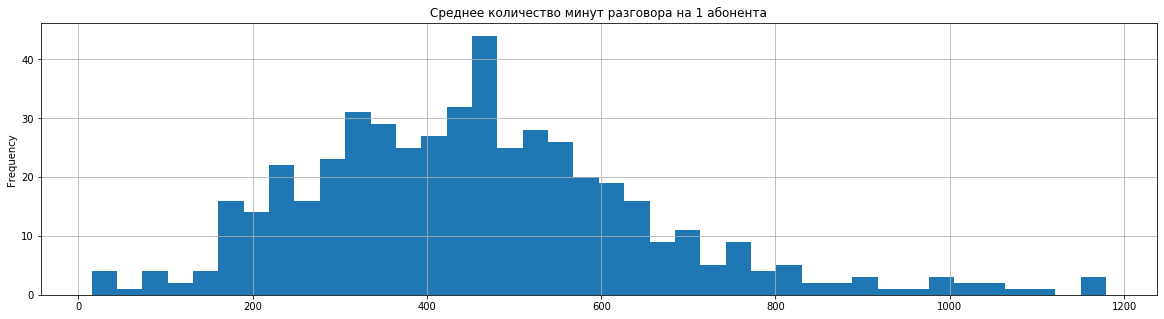

In [47]:
calls_statistics_duration['mean'].plot(kind='hist', grid=True, bins=40, figsize=(20, 5),\
title='Среднее количество минут разговора на 1 абонента')

In [48]:
calls_statistics_duration['std_dev'].describe()

count    492.000000
mean     134.867276
std      115.423483
min        0.000000
25%       67.500000
50%      109.200000
75%      159.450000
max      956.700000
Name: std_dev, dtype: float64

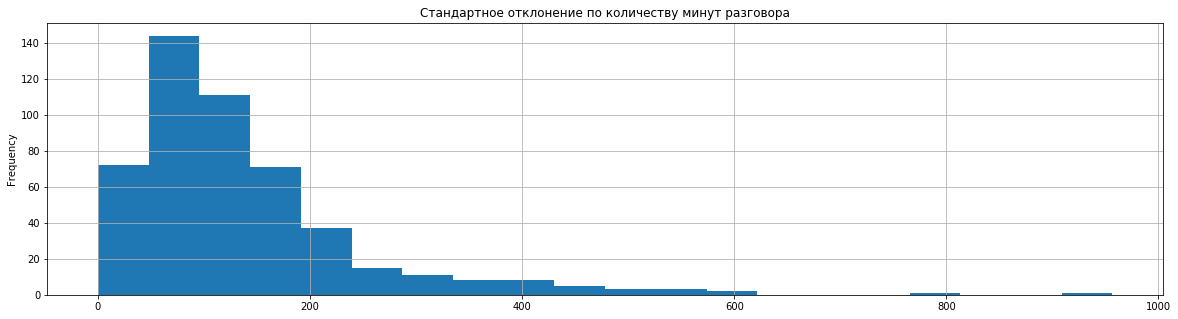

In [49]:
calls_statistics_duration['std_dev'].plot(kind='hist', grid=True, bins=20, figsize=(20, 5),\
title='Стандартное отклонение по количеству минут разговора')

<span style="text-decoration:underline">Выводы по данным о количестве минут разговора, израсходованных абонентами:</span>

1. Мы видим, что распределение среднего количества минут, которые использует абонент в течение года - нормальное: на гистограмме отчетливо видна мода распределения - где-то на отметке 470-490 минут в месяц, медиана и среднее значение очень близки друг к другу, что говорит нам об относительно небольшом размахе выборки и отсутствии явных смещений в ту или иную сторону

2. В среднем абоненты тратят 458 минут разговоров в месяц, что вписывается в оплаченный лимит в рамках тарифа "Smart"

3. 3/4 абонентов тратят незначительно больше 500 предоплаченных минут (561 минуту в месяц)

4. Средняя величина стандартного отклонения для всей выборки - 135 минут

5. Мы видим, что распределение пользователей по величине стандартного отклонения в меньшей степени похоже на нормальное - явно виден "хвост" из значений. Мы видим, что некоторая относительно небольшая группа пользователей пользуется услугами голосовой связи с меньшей регулярностью - частота падает ниже 20 значений в районе отметки около 230 минут. Отдельные редки значения встречаются в том числе и на отметках в 400, 600 и 800 минут 

In [50]:
#формируем сводную таблицу, в которой будем хранить средние значения по всем типам услуг с идентификаторами пользователей
users_agg_statistics = users.join(calls_statistics_duration, on='user_id')[['user_id', 'tariff', 'mean', 'std_dev']]
users_agg_statistics.columns=['user_id', 'tariff', 'mean_calls', 'std_calls']
users_agg_statistics = users_agg_statistics.fillna(0)

In [51]:
#пример таблицы с данными о среднем количестве израсходованных минут и стандартном отклонении
users_agg_statistics.sample(5)

,user_id,tariff,mean_calls,std_calls
472,1472,smart,532.8,103.6
47,1047,smart,564.3,395.5
492,1492,smart,544.0,224.1
118,1118,smart,668.8,102.1
127,1127,smart,249.3,71.0


In [52]:
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'smart'].describe()

,user_id,mean_calls,std_calls
count,351.000000,351.000000,351.000000
mean,1244.133903,418.452137,124.383761
std,144.985228,146.515632,102.328375
min,1001.000000,0.000000,0.000000
25%,1120.000000,315.950000,68.650000
50%,1236.000000,424.900000,103.100000
75%,1371.500000,518.600000,150.600000
max,1499.000000,891.500000,768.600000


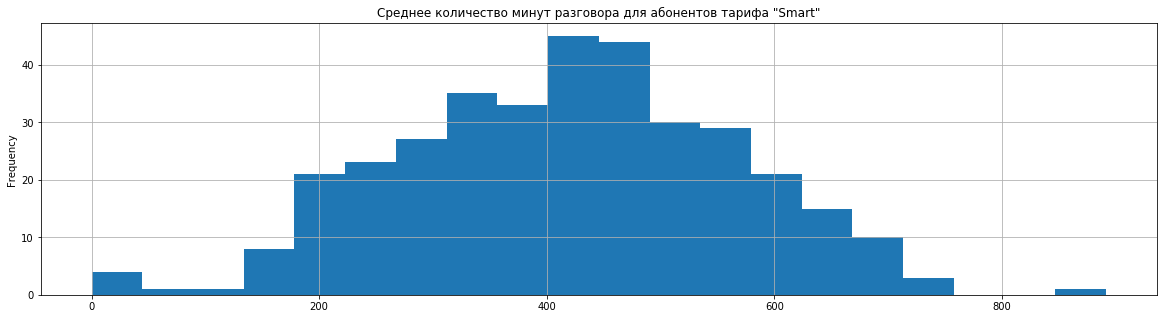

In [53]:
#взглянем на цифры минут разговора для тарифа "Smart"
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'smart', 'mean_calls']\
.plot(kind='hist', grid=True, bins=20, figsize=(20, 5), title='Среднее количество минут разговора для абонентов тарифа "Smart"')

In [54]:
#Группа пользователей тарифа "Smart", в которой среднее количество израсходованных в месяц минут превышает
#включенное в тарифный план предопределенное количество
users_agg_statistics.loc[(users_agg_statistics['tariff'] == 'smart') &\
(users_agg_statistics['mean_calls'] > 500), 'mean_calls'].describe()

count    102.000000
mean     591.771569
std       68.481735
min      501.000000
25%      539.850000
50%      577.200000
75%      633.350000
max      891.500000
Name: mean_calls, dtype: float64

In [55]:
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'ultra'].describe()

,user_id,mean_calls,std_calls
count,149.000000,149.000000,149.000000
mean,1262.140940,524.970470,152.322148
std,142.976516,283.900887,140.895883
min,1000.000000,0.000000,0.000000
25%,1143.000000,320.800000,60.900000
50%,1276.000000,515.800000,119.700000
75%,1379.000000,746.300000,206.900000
max,1495.000000,1179.400000,956.700000


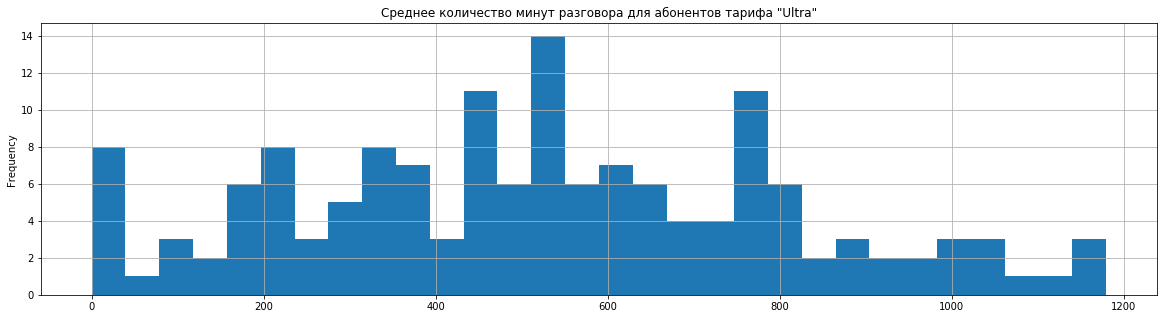

In [56]:
#взглянем на цифры минут разговора для тарифа "Ultra"
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'ultra', 'mean_calls']\
.plot(kind='hist', grid=True, bins=30, figsize=(20, 5), title='Среднее количество минут разговора для абонентов тарифа "Ultra"')

<span style="text-decoration:underline">Выводы для распределения абонентов по тарифным планам:</span>

1. Пропорция абонентов тарифов Smart и Ultra в выборке равна 70/30 соответственно
2. Среди пользователей тарифа Smart наблюдается группа тех, среднее значение израсходованных минут разговора в разрезе года для которых превышает включенные в тариф 500 минут (от 501 до 892 минут). Эта группа составляет около 29% от всех пользователей тарифа Smart в выборке или около 20% от всех пользователей в выборке. 
3. Отталкиваясь от средних значений количества минут, мы можем говорить, что в среднем абоненты тарифа Smart, которым не хватает голосового пакета, доплачивают от 3 до 1176 рублей в месяц за минуты разговоров
4. Распределение в группе пользователей Smart в большей степени похоже на классическое нормальное распределение, что видно на гистограмме. 
5. Абоненты тарифа Ultra, напротив, зачастую не утилизируют в полной мере включенный голосовой пакет. Среднее количество используемых минут абонентами этого тарифного плана составляет около 125% от среднего количества минут, используемого абонентами тарифа Smart (525 минут и 419 минут соответственно). При этом максимальное значение среднего количества минут по году 1180 минут, что составляет около 39% от общего количества минут, предоставляемого абонентам тарифа Ultra ежемесячно. 
6. Мы видим, что средняя величина стандартного отклонения по количеству израсходованных минут для абонентов тарифного плана Ultra составляет 152 минуты против 124 у тарифа Smart - из этого мы можем сделать предположение о меньшей "регулярности" использования голосовой связи абонентами более дорого тарифа. 

<a href='#Оглавление'> К оглавлению</a>

<a id='Интернет'></a>
#### 2.3.2 Интернет

In [57]:
#формируем сводную таблицу, в которой будем хранить средние значения по всем типам услуг с идентификаторами пользователей
users_agg_statistics = users_agg_statistics.join(internet_statistics_mb, on='user_id')[['user_id', 'tariff', 'mean_calls',\
'std_calls', 'mean', 'std_dev']]
users_agg_statistics.columns=['user_id', 'tariff', 'mean_calls', 'std_calls', 'mean_mb', 'std_mb']
users_agg_statistics = users_agg_statistics.fillna(0)
#мы дополнили таблицу со сводными данными по типам связи информацией о количестве используемого абонентами трафика

In [58]:
users_agg_statistics.sample(5)

,user_id,tariff,mean_calls,std_calls,mean_mb,std_mb
340,1340,smart,429.8,145.5,16822.4,5255.6
289,1289,ultra,1171.0,85.3,14873.5,2827.4
141,1141,smart,211.0,0.0,14848.0,0.0
396,1396,ultra,467.3,49.8,8922.3,3361.3
3,1003,ultra,764.4,223.4,11465.8,2354.4


In [59]:
#значения для тарифа Smart
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'smart'].describe()

,user_id,mean_calls,std_calls,mean_mb,std_mb
count,351.000000,351.000000,351.000000,351.000000,351.000000
mean,1244.133903,418.452137,124.383761,16190.746154,4736.557835
std,144.985228,146.515632,102.328375,3724.196096,3651.886281
min,1001.000000,0.000000,0.000000,0.000000,0.000000
25%,1120.000000,315.950000,68.650000,13943.350000,2646.700000
50%,1236.000000,424.900000,103.100000,16276.000000,4102.300000
75%,1371.500000,518.600000,150.600000,18649.100000,5885.900000
max,1499.000000,891.500000,768.600000,27321.000000,24304.700000


In [60]:
#значения для тарифа Ultra
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'ultra'].describe()

,user_id,mean_calls,std_calls,mean_mb,std_mb
count,149.000000,149.000000,149.000000,149.000000,149.000000
mean,1262.140940,524.970470,152.322148,19497.167114,5926.581879
std,142.976516,283.900887,140.895883,8436.401237,4279.993175
min,1000.000000,0.000000,0.000000,0.000000,0.000000
25%,1143.000000,320.800000,60.900000,13562.800000,3362.800000
50%,1276.000000,515.800000,119.700000,18846.300000,5060.100000
75%,1379.000000,746.300000,206.900000,25824.600000,7632.200000
max,1495.000000,1179.400000,956.700000,38502.000000,22100.600000


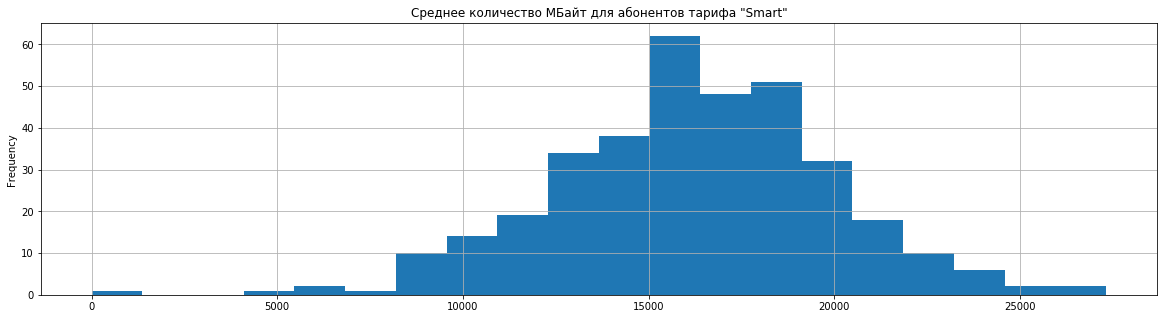

In [61]:
#взглянем на цифры для тарифа "Smart"
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'smart', 'mean_mb']\
.plot(kind='hist', grid=True, bins=20, figsize=(20, 5), title='Среднее количество МБайт для абонентов тарифа "Smart"')

In [62]:
#Группа пользователей тарифа "Smart", в которой среднее количество израсходованных в месяц мегабайт превышает
#включенное в тарифный план предопределенное количество
users_agg_statistics.loc[(users_agg_statistics['tariff'] == 'smart') &\
(users_agg_statistics['mean_mb'] > 15360), 'mean_mb'].describe()

count      218.000000
mean     18427.649083
std       2370.745181
min      15369.600000
25%      16504.450000
50%      17971.600000
75%      19665.300000
max      27321.000000
Name: mean_mb, dtype: float64

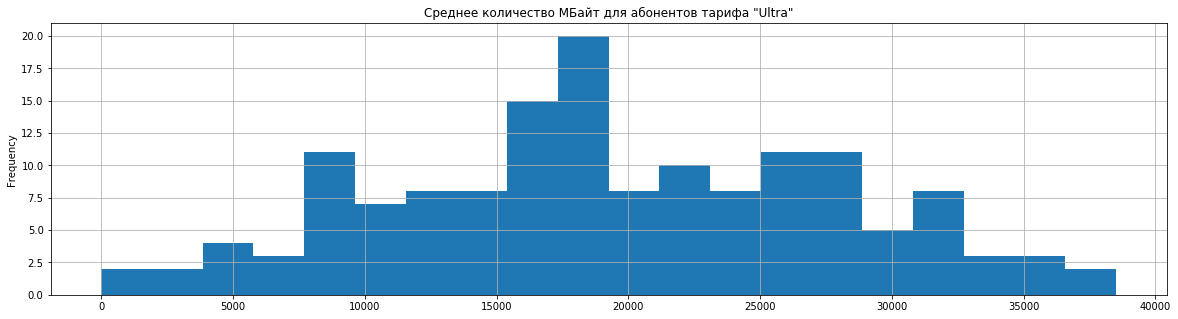

In [63]:
#взглянем на цифры для тарифа "Ultra"
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'ultra', 'mean_mb']\
.plot(kind='hist', grid=True, bins=20, figsize=(20, 5), title='Среднее количество МБайт для абонентов тарифа "Ultra"')

In [64]:
#Группа пользователей тарифа "Ultra", в которой среднее количество израсходованных в месяц мегабайт превышает
#включенное в тарифный план предопределенное количество
users_agg_statistics.loc[(users_agg_statistics['tariff'] == 'ultra') &\
(users_agg_statistics['mean_mb'] > 30720), 'mean_mb'].describe()

count       17.000000
mean     33437.194118
std       2383.673355
min      30768.300000
25%      31684.700000
50%      32491.700000
75%      34747.300000
max      38502.000000
Name: mean_mb, dtype: float64

1. Мы видим, что медианное и среднее значение среднего количества мегабайт израсходованных пользователями тарифа Smart близки друг к другу (16276 и 16191 МБайт соответственно). Медиана больше среднего значения - из этого мы делаем предположение о более "равномерном" использовании включенного пакета минут. При этом, смещение среднего влево относительно медианы говорит о том, что среди пользователей тарифа Smart много тех, кто использует Интернет в минимальном объеме, либо не использует вообще - вероятно, эти пользователи предпочитают использовать другие услуги (например, голосовую связь). 

2. Распределение близко к "классическому" нормальному по виду гистограммы: ярко выраженная мода, высокая плотность значений в центральной части графика, выбросы небольшие с исчезающе малой плотностью 

3. В среднем, пользователи тарифа Smart используют 15.8 ГБайт трафика в месяц (около 105% от квоты), что равносильно среднемесячной доплате за Интернет в 160 рублей

4. Диапазон значений для пользователей, которые в среднем используют больше трафика, чем включено в тариф находтся между отметками 15370 МБайт и 27321 МБайт, что означает среднемесячную доплату за Интернет для пользователей тарифа Smart в диапазоне от 1.95 до 2336.13 рублей. 

5. Количество пользователей, превышающих квоту на трафик больше того же количества пользователей, превышающих лимит на минуты звонков - 218 и 102 человека соответственно. Это около 62% от общего числа пользователей тарифа Smart в выборке. Гипотеза - спрос на услуги связи смещается в направлении Интернета в связи с развитием коммуникации. Проверить ее можно путем анализа аналогичной выборки с данными об устройстве, которым пользуется каждый из абонентов (вероятно, более "продвинутая" модель телефона будет означать высокую вероятность повышенного потребления трафика)

6. Средняя величина отклонения для пользователей тарифа Smart меньше в абсолютных значениях, чем аналогичное значение для тарифа Ultra (4737 и 5927 МБайт соответственно) - скорее всего это обусловлено большей "степенью свободы" у пользователей дорогого тарифного плана (все таки лимит МБайт вдвое больше). 

7. Мы видим, что в случае обоих тарифов максимальная величина отклонения превышает 20 ГБайт - вероятно в этой группе находятся все те выбросы, которыю задают нам максимальную планку при оценке размаха выборки. Можно предположить, что резкий "пиковый" спрос на трафик у таких пользователей был обусловлен использованием мобильного интернета в некой разовой нестандартной ситуации - например, при отсутствии друго источника интернета дома или в офисе. 

8. Среднее количество израсходованный мегабайт трафика для пользователей тарифа Ultra - 19498 МБайт (около 64% от квоты). Медианное значение - 18847 МБайт. Мы видим, что в данном случае среднее смещено вправо относительно медианы - значит в выборке по тарифному плану Ultra больше "высоких" значений - вероятно, у спроса на дорогой тариф наблюдается прямая корреляция со спросом на трафик.

9. Если сравнить потребление трафика с потреблением минут у пользователей тарифа Ultra, то мы увидим существенное отличие: в выборке есть пользователи, которые не только выбирают весь доступный лимит, но и уходят за его пределы - таких пользователей в выборке 17 (около 11% от пользователей тарифа Ultra).

10. В среднем, пользователи дорогого тарифа переплачивают около 398.14 рублей за интернет. Диапазон переплат лежит между отметками 7.03 и 1139.94 рубля. 

<a href='#Оглавление'> К оглавлению</a>

<a id='Сообщения'></a>
#### 2.3.3 Сообщения

In [65]:
users_agg_statistics = users_agg_statistics.join(messages_statistics, on='user_id')[['user_id', 'tariff', 'mean_calls',\
'std_calls', 'mean_mb', 'std_mb', 'mean', 'std_dev']]
users_agg_statistics.columns=['user_id', 'tariff', 'mean_calls', 'std_calls', 'mean_mb', 'std_mb', 'mean_msg',\
                             'std_msg']
users_agg_statistics = users_agg_statistics.fillna(0)
#мы дополнили таблицу со сводными данными по типам связи информацией о количестве сообщений

In [66]:
users_agg_statistics.sample(5)

,user_id,tariff,mean_calls,std_calls,mean_mb,std_mb,mean_msg,std_msg
456,1456,smart,723.2,326.0,20681.4,8512.9,0.0,0.0
9,1009,smart,218.9,70.9,17762.4,5255.9,11.0,4.0
247,1247,smart,436.9,138.6,18869.5,5396.6,26.0,8.5
49,1049,ultra,588.0,117.9,7930.3,2528.1,0.0,0.0
144,1144,smart,403.4,154.7,14780.7,5888.8,54.0,21.5


In [67]:
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'smart'].describe()

,user_id,mean_calls,std_calls,mean_mb,std_mb,mean_msg,std_msg
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,1244.133903,418.452137,124.383761,16190.746154,4736.557835,32.330199,8.700855
std,144.985228,146.515632,102.328375,3724.196096,3651.886281,26.478608,9.513084
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1120.000000,315.950000,68.650000,13943.350000,2646.700000,11.000000,1.400000
50%,1236.000000,424.900000,103.100000,16276.000000,4102.300000,27.500000,6.300000
75%,1371.500000,518.600000,150.600000,18649.100000,5885.900000,48.000000,12.700000
max,1499.000000,891.500000,768.600000,27321.000000,24304.700000,118.000000,54.600000


In [68]:
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'ultra'].describe()

,user_id,mean_calls,std_calls,mean_mb,std_mb,mean_msg,std_msg
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,1262.140940,524.970470,152.322148,19497.167114,5926.581879,53.722819,14.159732
std,142.976516,283.900887,140.895883,8436.401237,4279.993175,46.374823,15.501425
min,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1143.000000,320.800000,60.900000,13562.800000,3362.800000,18.000000,2.400000
50%,1276.000000,515.800000,119.700000,18846.300000,5060.100000,45.000000,9.100000
75%,1379.000000,746.300000,206.900000,25824.600000,7632.200000,84.000000,21.000000
max,1495.000000,1179.400000,956.700000,38502.000000,22100.600000,192.000000,81.900000


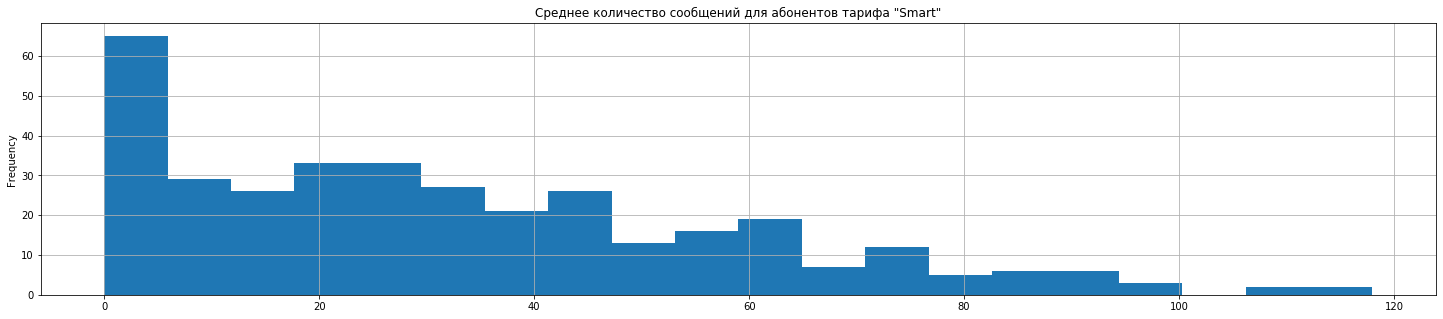

In [69]:
#взглянем на цифры для тарифа "Smart"
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'smart', 'mean_msg']\
.plot(kind='hist', grid=True, bins=20, figsize=(25, 5), title='Среднее количество сообщений для абонентов тарифа "Smart"')

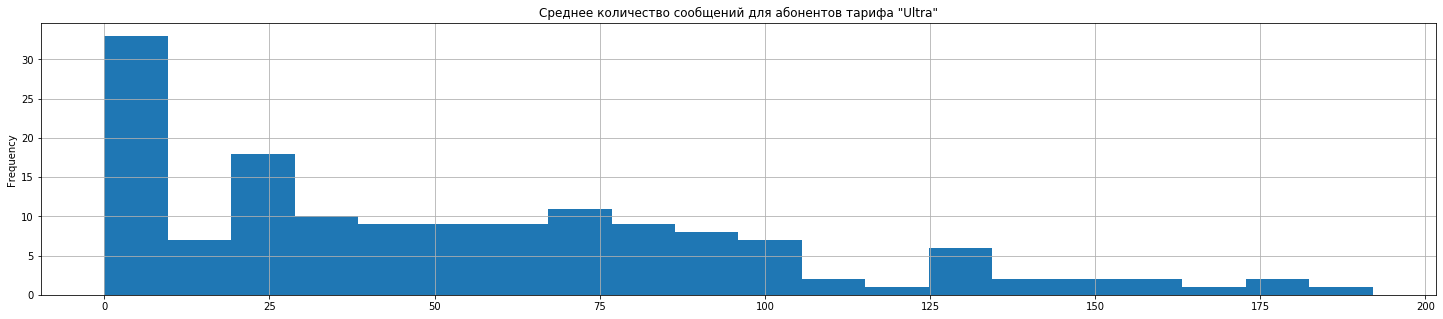

In [70]:
#взглянем на цифры для тарифа "Smart"
users_agg_statistics.loc[users_agg_statistics['tariff'] == 'ultra', 'mean_msg']\
.plot(kind='hist', grid=True, bins=20, figsize=(25, 5), title='Среднее количество сообщений для абонентов тарифа "Ultra"')

In [71]:
users_agg_statistics.loc[(users_agg_statistics['tariff'] == 'smart') & (users_agg_statistics['mean_msg'] > 50)].describe()

,user_id,mean_calls,std_calls,mean_mb,std_mb,mean_msg,std_msg
count,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000,80.000000
mean,1251.900000,444.673750,114.55625,16282.621250,4395.401250,71.452500,17.040000
std,147.194145,133.280529,81.58582,3639.777125,3439.673325,15.691899,11.650323
min,1008.000000,192.500000,0.00000,5391.200000,0.000000,52.000000,0.000000
25%,1133.000000,345.550000,70.52500,13569.900000,2611.475000,59.000000,9.375000
50%,1236.000000,456.150000,99.45000,16055.200000,3823.700000,66.000000,15.550000
75%,1393.000000,541.775000,148.22500,18842.075000,5510.675000,82.000000,21.525000
max,1488.000000,711.900000,504.20000,25112.300000,21425.200000,118.000000,54.600000


In [72]:
print('Доля пользователей тарифа Smart, которые укладываются в лимит сообщений: {0:.1f}%'.\
format(len(users_agg_statistics.loc[(users_agg_statistics['mean_msg'] <= 50) &\
(users_agg_statistics['tariff'] == 'smart')]) /\
len(users_agg_statistics.loc[users_agg_statistics['tariff'] == 'smart'])* 100))

print('Доля пользователей тарифа Ultra, которые укладываются в лимит сообщений: {0:.1f}%'.\
format(len(users_agg_statistics.loc[(users_agg_statistics['mean_msg'] <= 1000) &\
(users_agg_statistics['tariff'] == 'ultra')]) /\
len(users_agg_statistics.loc[users_agg_statistics['tariff'] == 'ultra'])* 100))

Доля пользователей тарифа Smart, которые укладываются в лимит сообщений: 77.2%
Доля пользователей тарифа Ultra, которые укладываются в лимит сообщений: 100.0%


1. Мы видим, что распределение для количества использованных текстовых сообщений радикально отличается от распределения звонков и сообщений - значение не сконцентрированы вокруг среднего. В данном случае мы наблюдаем ступечантое сокращение частоты значений в выборке по мере роста количества используемых сообщений. 

2. "Тяжелая" часть графика для тарифов Smart и Ultra заканчивается в районе отметок 45-50 и 100-105 сообщений соответственно. Такое распределение говорит нам о низкой/снижающейся популярности текстовых сообщений. Учитывая тенденцию на рост спроса на трафик, можем предположить, что для коммуникации в формате текстовых сообщений пользователи предпочитают использовать онлайн-мессенджеры. 

3. 77.2% пользователей тарифа Smart укладываются в квоту сообщений. 100% пользователей тарифа Ultra укладываются в отведенную квоту сообщений. 

4. При среднем количестве количестве сообщений для пользователей тарифа Smart равном 32, среднее стандартное отклонение около 9, то есть на +2 сигмы вправо распрделение "вписывается" в квоту 50 сообщений.

5. 80 пользователей тарифа Smart в среднем превышают квоту на количество используемых сообщений. Среднее значение в этой группе - 72 сообщения в месяц (то есть, средня переплата за текстовые сообщения составляет около 66 рублей). Диапазон доплаты лежит между отметками 6 и 204 рубля). 

6. В среднем пользователи тарифа Ultra используют 5.4% доступного пакета сообщений

<a href='#Оглавление'> К оглавлению</a>

<a id='Проверка гипотез'></a>
## 3. Проверка гипотез

<a id='Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается'></a>
### 3.1 Гипотеза 1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается


В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Средняя выручка пользователей тарифов "Ультра" и "Смарт" одинакова**
- **Альтернативная гипотеза (H₀): Средняя выручка пользователей тарифов "Ультра" и "Смарт" различается**

Для проверки используем максимально высокий критерий статистической значимости, предполагая, что размер выборки может дать несколько искаженные данные. 

Для проверки гипотезы нам необходимы два ряда значений в соответствии с количеством тарифов. Данные по выручке от каждого пользователя по месяцам у нас уже есть в таблице `overall_earnings`, поэтому достаточно дополнить ее среднегодовым значением выручки для каждого пользователя. Для этой цели мы используем упрощенную функцию, которую ранее использовали для расчет мер центральной тенденции по трем видам коммуникации. 

In [73]:
overall_earnings.sample(5)

,user_id,reg_date,tariff,reg_year,reg_month,churn_month,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December
220,1220,2018-11-22,smart,2018,11,0,0,0,0,0,0,0,0,0,0,0,500,2398
94,1094,2018-05-28,ultra,2018,5,0,0,0,0,0,3000,3000,3000,3000,3000,3000,3000,3000
228,1228,2018-04-17,smart,2018,4,0,0,0,0,500,1805,1490,1111,894,500,728,500,1250
205,1205,2018-10-21,smart,2018,10,0,0,0,0,0,0,0,0,0,0,500,1432,2866
309,1309,2018-10-05,ultra,2018,10,0,0,0,0,0,0,0,0,0,0,3000,3000,3000


In [74]:
def mean_earnigs_calculator(row):
    base = [] #формируем пустой список, который мы наполним значениями для анализа 
    for i in range (6, len(row)): #для каждой ячейки в строке смотрим значение, если больше нуля - добавляем в список
        if row[i] > 0:
            base.append(row[i])
        else:
            continue
    row['mean_earnings'] = round(sum(base) / len(base), 2) #вычисляем среднее. Среднее будет равно значению, если у нас есть
    return row

In [75]:
overall_earnings = overall_earnings.apply(mean_earnigs_calculator, axis=1)

In [76]:
overall_earnings.sample(5)

,user_id,reg_date,tariff,reg_year,reg_month,churn_month,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,mean_earnings
429,1429,2018-01-26,smart,2018,1,0,500,1862,2140,1144,1901,2121,2884,500,1040,1411,1177,1710,1532.50
169,1169,2018-06-25,smart,2018,6,0,0,0,0,0,0,500,1070,1213,1794,1376,1282,500,1105.00
480,1480,2018-02-14,smart,2018,2,9,0,500,500,663,504,500,1367,641,500,0,0,0,646.88
165,1165,2018-10-14,ultra,2018,10,0,0,0,0,0,0,0,0,0,0,3000,4680,3184,3621.33
261,1261,2018-10-30,smart,2018,10,0,0,0,0,0,0,0,0,0,0,500,4570,5609,3559.67


In [77]:
print('Среднегодовая выручка от пользователя тарифа Smart: {0:.2f} рублей'\
      .format(overall_earnings.loc[overall_earnings['tariff'] == 'smart', 'mean_earnings'].mean()))
print('Среднегодовая выручка от пользователя тарифа Ultra: {0:.2f} рублей'\
      .format(overall_earnings.loc[overall_earnings['tariff'] == 'ultra', 'mean_earnings'].mean()))
print('Общая среднегодовая выручка от пользователей тарифа Smart: {0:.2f} рублей'\
      .format(overall_earnings.loc[overall_earnings['tariff'] == 'smart', 'mean_earnings'].sum()))
print('Общая среднегодовая выручка от пользователей тарифа Ultra: {0:.2f} рублей'\
      .format(overall_earnings.loc[overall_earnings['tariff'] == 'ultra', 'mean_earnings'].sum()))

Среднегодовая выручка от пользователя тарифа Smart: 1215.18 рублей
Среднегодовая выручка от пользователя тарифа Ultra: 3125.47 рублей
Общая среднегодовая выручка от пользователей тарифа Smart: 426529.06 рублей
Общая среднегодовая выручка от пользователей тарифа Ultra: 465694.39 рублей


In [1]:
alpha = 0.1 #зададим критический уровень статистической значимости в 10%

results = st.ttest_ind(
    overall_earnings.loc[overall_earnings['tariff'] == 'smart', 'mean_earnings'], 
    overall_earnings.loc[overall_earnings['tariff'] == 'ultra', 'mean_earnings'],
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

NameError: name 'st' is not defined

Значения, которые мы анализируем противоречат нулевой гипотезе. Располагая данными о среднегодовой выручке пользователей разных тарифов, мы можем говорить о разной выручке от пользователей разных тарифов. 

<a href='#Оглавление'> К оглавлению</a>

In [79]:
overall_earnings.loc[overall_earnings['tariff'] == 'smart', 'mean_earnings'].describe()

count     351.000000
mean     1215.182507
std       588.263221
min       500.000000
25%       776.585000
50%      1071.250000
75%      1540.180000
max      4228.670000
Name: mean_earnings, dtype: float64

In [80]:
overall_earnings.loc[overall_earnings['tariff'] == 'ultra', 'mean_earnings'].describe()

count     149.000000
mean     3125.465705
std       280.110375
min      3000.000000
25%      3000.000000
50%      3000.000000
75%      3021.000000
max      4261.500000
Name: mean_earnings, dtype: float64

<a id='Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов'></a>
### 3.2 Гипотеза 2 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

В соответствии с правилами формулирования гипотез:

- **Нулевая гипотеза (H₀): Средняя выручка пользователей из Москвы и других регионов одинакова**
- **Альтернативная гипотеза (H₀): Средняя выручка пользователей из Москвы и других регионов различается**

Для проверки используем максимально высокий критерий статистической значимости, предполагая, что размер выборки может дать несколько искаженные данные. 

Для проверки гипотезы нам необходимо добавить в таблицу `overall_earnings` столбец с городами. 

In [81]:
users = users.set_index('user_id') #для join назначаем столбец идентификаторов пользователей индексами строк
users_cities = users['city'] #выделяем series с городами
overall_earnings = overall_earnings.join(users_cities, on='user_id') #соединяем его с таблицей выручки
overall_earnings.sample(5) #смотрим на полученный семпл

,user_id,reg_date,tariff,reg_year,reg_month,churn_month,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,mean_earnings,city
311,1311,2018-08-03,smart,2018,8,0,0,0,0,0,0,0,0,661,895,551,932,625,732.80,Тверь
444,1444,2018-11-07,smart,2018,11,0,0,0,0,0,0,0,0,0,0,0,728,1878,1303.00,Нижний Новгород
490,1490,2018-04-03,smart,2018,4,0,0,0,0,500,1673,1315,536,878,500,1542,1159,588,965.67,Москва
400,1400,2018-08-24,smart,2018,8,0,0,0,0,0,0,0,0,500,1307,2926,2679,2095,1901.40,Москва
471,1471,2018-02-26,ultra,2018,2,0,0,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000,3000.00,Вологда


Так как детализация до уровня городов нам не требуется, при помощи функции мы можем перезаполнить столбец двумя значениями: "Москва" и "Регион". 

In [82]:
def hyp2_transformer(row):
    if row['city'] == 'Москва':
        row['city'] = row['city']
    else: 
        row['city'] = 'Регион'
    return row

In [83]:
overall_earnings = overall_earnings.apply(hyp2_transformer, axis=1)

In [84]:
overall_earnings.sample(5)

,user_id,reg_date,tariff,reg_year,reg_month,churn_month,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,mean_earnings,city
27,1027,2018-04-10,smart,2018,4,0,0,0,0,500,2734,500,1349,2363,1214,1859,2332,1899,1638.89,Регион
441,1441,2018-11-07,smart,2018,11,0,0,0,0,0,0,0,0,0,0,0,2400,2621,2510.50,Регион
297,1297,2018-12-04,smart,2018,12,0,0,0,0,0,0,0,0,0,0,0,0,1213,1213.00,Регион
32,1032,2018-01-04,smart,2018,1,0,2217,500,2323,858,866,1234,1342,2354,1069,500,2085,1044,1366.00,Регион
395,1395,2018-01-06,smart,2018,1,0,2069,752,2164,1610,500,1446,658,1284,509,1800,1663,1067,1293.50,Москва


In [85]:
print('Среднегодовая выручка от пользователя в Москве: {0:.2f} рублей'\
      .format(overall_earnings.loc[overall_earnings['city'] == 'Москва', 'mean_earnings'].mean()))
print('Среднегодовая выручка от пользователя в регионах: {0:.2f} рублей'\
      .format(overall_earnings.loc[overall_earnings['city'] == 'Регион', 'mean_earnings'].mean()))

Среднегодовая выручка от пользователя в Москве: 1765.21 рублей
Среднегодовая выручка от пользователя в регионах: 1789.20 рублей


Видим, что среднегодовые значения близки друг к другу. Перейдем к проверке гипотезы:

In [86]:
alpha = 0.1 #зададим критический уровень статистической значимости в 10%

results = st.ttest_ind(
    overall_earnings.loc[overall_earnings['city'] == 'Москва', 'mean_earnings'], 
    overall_earnings.loc[overall_earnings['city'] == 'Регион', 'mean_earnings'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.8335246945127277
Не получилось отвергнуть нулевую гипотезу


In [87]:
overall_earnings.loc[overall_earnings['city'] == 'Москва', 'mean_earnings'].describe()

count      99.000000
mean     1765.210505
std      1028.237622
min       500.000000
25%       866.915000
50%      1510.570000
75%      3000.000000
max      3784.830000
Name: mean_earnings, dtype: float64

In [88]:
overall_earnings.loc[overall_earnings['city'] == 'Регион', 'mean_earnings'].describe()

count     401.000000
mean     1789.196035
std      1013.372895
min       500.000000
25%       887.890000
50%      1491.200000
75%      3000.000000
max      4261.500000
Name: mean_earnings, dtype: float64

Данные не противоречат нулевой гипотезе. Таким образом, мы можем говорить о сопоставимой среднегодовой выручке с 1 пользователя в Москве и в регионах. 

<a href='#Оглавление'> К оглавлению</a>

<a id='Дополнительные расчеты'></a>
## 4. Дополнительные расчеты

In [89]:
#срез пользователей тарифа Smart, которые регулярно превышают лимит минут разговора и мегабайт, включенных в тариф
users_agg_statistics.loc[(users_agg_statistics['tariff'] == 'smart') &\
(users_agg_statistics['mean_calls'] > 500) & (users_agg_statistics['mean_mb'] > 15360)].describe()

,user_id,mean_calls,std_calls,mean_mb,std_mb,mean_msg,std_msg
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,1278.731343,591.458209,150.598507,18368.222388,4846.932836,34.195522,7.647761
std,139.597428,60.329103,126.150776,2266.887947,4152.759229,27.849947,9.954721
min,1047.000000,502.500000,0.000000,15369.600000,0.000000,0.000000,0.000000
25%,1161.500000,544.600000,74.700000,16576.850000,2622.700000,11.500000,0.000000
50%,1274.000000,589.800000,134.800000,17921.700000,4102.300000,28.000000,5.300000
75%,1410.000000,625.100000,192.300000,19542.100000,6246.150000,55.500000,10.650000
max,1492.000000,723.200000,544.500000,25112.300000,21425.200000,118.000000,51.500000


In [90]:
print('Доля абонентов с превышением количества минут и МБ: {0:.1f}%'.format(len(users_agg_statistics.loc[(users_agg_statistics['tariff'] == 'smart') &\
(users_agg_statistics['mean_calls'] > 500) & (users_agg_statistics['mean_mb'] > 15360)])\
/ len(users_agg_statistics.loc[users_agg_statistics['tariff'] == 'smart']) * 100))

Доля абонентов с превышением количества минут и МБ: 19.1%


<a href='#Оглавление'> К оглавлению</a>

<a id='Выводы'></a>
## 5. Выводы

1. 70% выборки - абоненты тарифа Smart. 30% - абоненты тарифа Ultra. 

2. Среднегодовая выручка от пользователя тарифа Smart составляет 1215.18 рублей, что составляет 221% от суммы ежемесячной абонентской платы.

3. Среднегодовая выручка от пользователя тарифа Smart составляет 3125.47 рублей, что составляет 160% от суммы ежемесячной абонентской платы.

4. Существенная доплата за дополнительные услуги наблюдается на обоих тарифных планах, что говорит об их несбалансированности - требуется углубленное исследование точек роста за счет которых возможно сегментирование пользователей различных услуг в рамках тарифа. Это возможно сделать, либо за счет расширения сетки тарифов, либо расширения пула дополнительных услуг, что потенциально даст более позитивное восприятие компании пользователями и стабильный доход с меньшим отклонением от среднего. 

5. Около 25%  пользователей тарифа Smart в среднем используют большее количество минут разговоров, чем предоставляет пакет со средним количеством минут превышения - 92 минуты (276 рублей). Возможно, предложение вида "дополнительные 150 минут за 300 рублей" позволило мы увеличить и стабилизировать поток выручки за счет этой группы пользователей.

6. Около 62% пользователей тарифа Smart в среднем превышают доступную квоту Интернет-трафика. Средний размер превышения около 0.8 ГБайт (160 рублей). Здесь можно рассмотреть несколько альтернативных вариантов: дополнительные пакеты вида "дополнительный 1/3/5 ГБайт за 180/450/600 рублей; исследование и сегментация трафика для дополнительных предложений расширенного или неограниченного лимита в зависимости от предпочтительного направления расхода трафика. 

7. Около 19% (67 человек) пользователей тарифа Smart в среднем превышают доступную квоту на минуты и трафик. В среднем превышение составляет 92 минуты и 2.94 ГБайт, что в сумме дает среднемесячную переплату по году в 864 рубля. Вероятно имеет смысл рассмотреть возможность создания промежуточных тарифных планов между Smart и Ultra для стабилизации и наращивания потока выручки. 

8. Среди пользователей тарифа Ultra никто не превышает доступный пакет минут. Максимальный уровень утилизации голосового пакета находится на уровне отметки в 30%. 

9. В среднем пользователи тарифного плана Ultra также превышают квоту доступного трафика. Среднее превышение составляет около 2.65 ГБайт (398 рублей). Это говорит о явной тенденции к росту спроса на трафик и уход других способов коммуникции в плоскость интернета. Так как Ultra - дорогой тарифный план, имеет смысл также рассмотреть опцию с дополнительными пакетами трафика, либо снятием лимита за отдельную плату (возможно, на отдельные направления расхода трафика).

10. Анализ количества используемых сообщений показал, что значение несущественно для тарифа Ultra - порядка 5% от пакета. Абоненты тарифного плана Smart иногда превышают квоту (около 23% от всех пользователей), однако превышение несущественное - среднее значение в группе "превышающих" - 72 сообщения. 3 квартиль по тарифу Smart лежит на отметке в 48 сообщений. Возможно, имеет смысл рассмотреть этот вид коммуникации как инструмент улучшения имиджа и предоставить "расширенный" пакет сообщений в рамках стандартного тарифного плана (например, увелить квоту до 100 сообщений)

11. Гипотеза о равенстве среднегодовой выручки для абонентов разных тарифных планов не нашла подтверждения, что неудивительно, учитывая значения, приведенные в пунктах 2 и 3

12. Гипотеза о равенстве среднегодовой выручки для абонентов из Москвы и региональных городов не противоречит нашим данным. С вероятностью около 83% мы можем получить идентичное или большее различие, что значительно больше критического уровня статистической значимости, который мы и так указали достаточно большим - 10%. 